In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

# matplotlib.rcParams: Matplotlib에서 그래프의 기본 스타일이나 설정을 전역으로 바꾸는 딕셔너리
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False
# 그래프의 축에 기본적으로 그리드를 표시하지 않도록 설정

1. 사전 훈련된 MobileNetV2 모델과 ImageNet의 클래스 이름들을 불러옴.

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions
     

In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    # 이미지를 MobiltNetV2 모델에 넣을 수 있도록 전처리하는 함수
  image = tf.cast(image, tf.float32)
  # 딥러닝 모델은 정수보다 float 타입을 선호하므로, 이미지를 32비트 float형으로 변환함.
  image = tf.image.resize(image, (224, 224))
  # MobileNetV2는 입력 사이즈가 224x224 여야 함.
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  # None은 axis=0 방향에 새로운 차원을 추가하는 것임.
  # 대부분의 딥러닝 모델은 한 번에 여러 장의 이미지를 처리할 수 있도록 설계되어 있어
  # 기본적인 입력 shape는 (Batch, Height, Width, Channels)로 만들어줘야 함.
  # 1장의 이미지를 입력하고 싶어도 (1, 224, 244, 3) 형태로 만들어줘야 함.
  return image
  # 전처리된 이미지 반환환

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    # 확률 벡터(probability vector)에서 가장 높은 클래스의 레이블을 가져오는 함수
    # probs: 모델이 출력한 확률값 벡터
  return decode_predictions(probs, top=1)[0][0]
  # decode_predictions(): ImageNet의 클래스 번호를 사람이 읽을 수 있는 라벨로 바꿔줌.
  # top=1: 가장 확률이 높은 1개 클래스만 가져오겠다는 뜻
  # [0][0]을 통해 최상위 클래스 하나만 뽑아 리턴
  # ex) ('n02099712', 'Labrador_retriever', 0.93)
  # 'n02099712': ImageNet 클래스 ID

2. 원본 이미지
Mirko CC-BY-SA 3.0의 래브라도 리트리버 샘플 이미지를 이용해 적대적 샘플을 생성함.
첫 단계로, 원본 이미지를 전처리하여 MobileNetV2 모델에 입력으로 제공함.

In [5]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


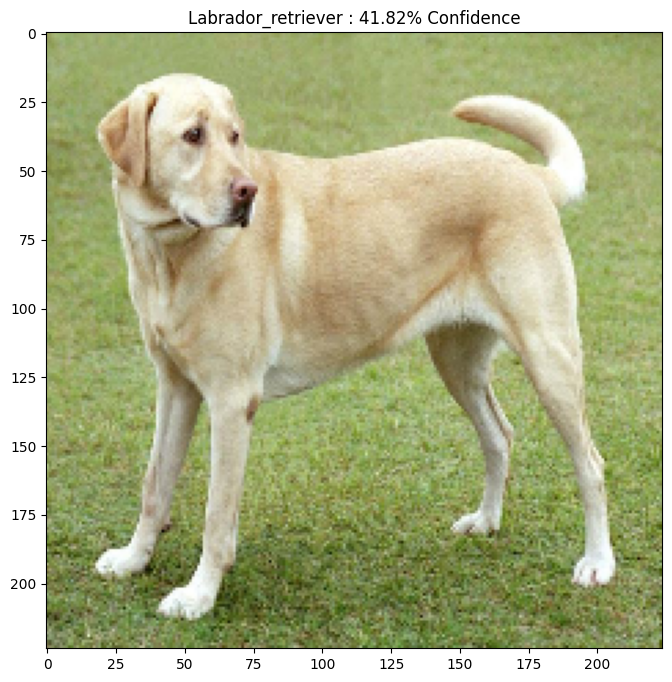

In [6]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

3. 적대적 이미지 생성하기
첫번째 단계는 샘플 생성을 위해 원본 이미지에 가하게 될 왜곡을 생성하는 것임.
앞서 살펴보았듯이, 왜곡을 생성할 때에는 입력 이미지에 대한 그래디언트를 사용함.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
# loss_object를 다중 클래스 분류 문제에서 많이 사용하는 손실 함수인 cross-entropy loss로 정의함.
# Categorical Crossentropy Loss? 정답(label)과 모델의 예측값(prediction) 사이의 차이를 수치화하는 손실 함수
# 정답은 1, 나머지는 0으로 표현된 one-hot 벡터
# 예측은 softmax를 통해 나온 확률값

def create_adversarial_pattern(input_image, input_label):
  # 적대적 패턴을 만드는 함수
  # input_label: 해당 이미지의 실제 라벨(one-hot 형식)
  with tf.GradientTape() as tape:
    # TensorFlow의 자동 미분 기능을 사용하기 위한 context
    tape.watch(input_image)
    # 추후에 미분할 예정임을 직접 알려주는 것(명시적으로 감시)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # 손실 함수에 대한 입력 이미지의 gradient 계산(이미지를 어떻게 바꿔야 손실이 커지는가?)
  
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  # gradient의 부호를 나타냄(양수는 1, 음수는 -1, 0은 그대로)
  # 이미지를 교란시킬 방향을 나타냄.
  
  return signed_grad

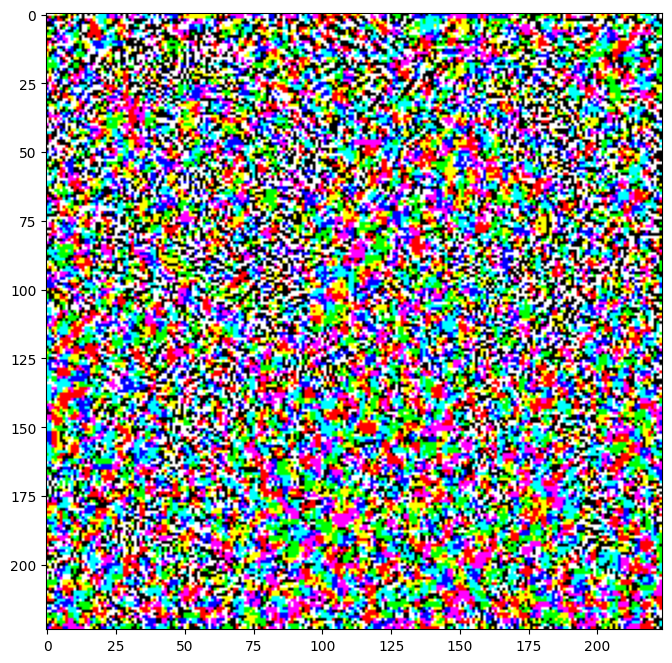

In [ ]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
# image_probs.shape[-1]은 클래스 수를 의미함.(1000개), one-hot 벡터의 길이
label = tf.reshape(label, (1, image_probs.shape[-1]))
# label이 배치 차원임.
# 모델에 넣을 때 일반적으로 배치 크기를 포함해야 하기 때문문

perturbations = create_adversarial_pattern(image, label)
# 앞서 정의했던 create_adversarial_pattern() 함수를 이용해서 주어진 이미지에 대한 gradient 방향을 만듦.
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]
# 적대적 교란 텐서는 보통 [-1, 1] 범위의 값을 가지는데 그대로 출력하면 시각적으로 보기 어려움.
# perturbations[0]: 배치 차원에서 첫 번째 이미지를 꺼냄.
# plt.imshow(...): 교란을 이미지처럼 시각화

왜곡 승수 엡실론(epsilon)을 바꿔가며 다양한 값들을 시도함.
위의 간단한 실험을 통해 엡실론의 값이 커질수록 네트워크를 혼란시키는 것이 쉬워짐을 알 수 있음. 
하지만 이는 이미지의 왜곡이 점점 더 뚜렷해진다는 단점을 동반함.

In [9]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


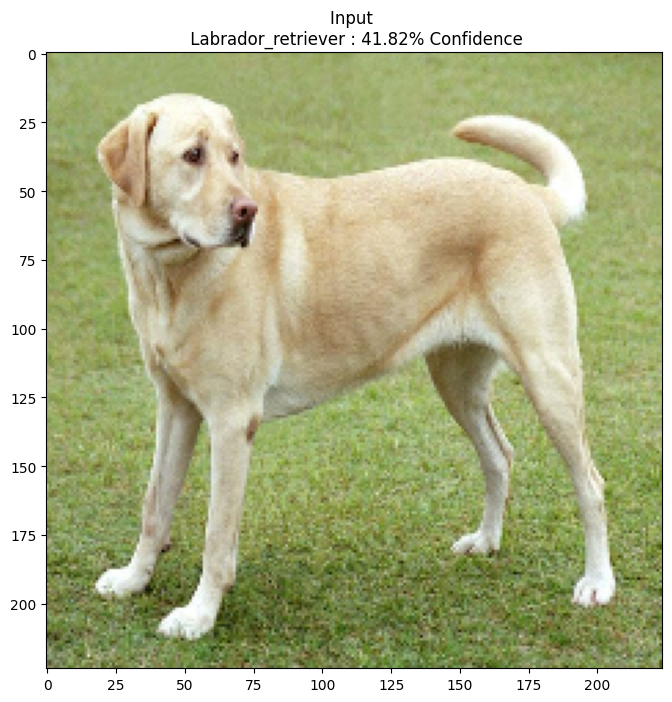

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


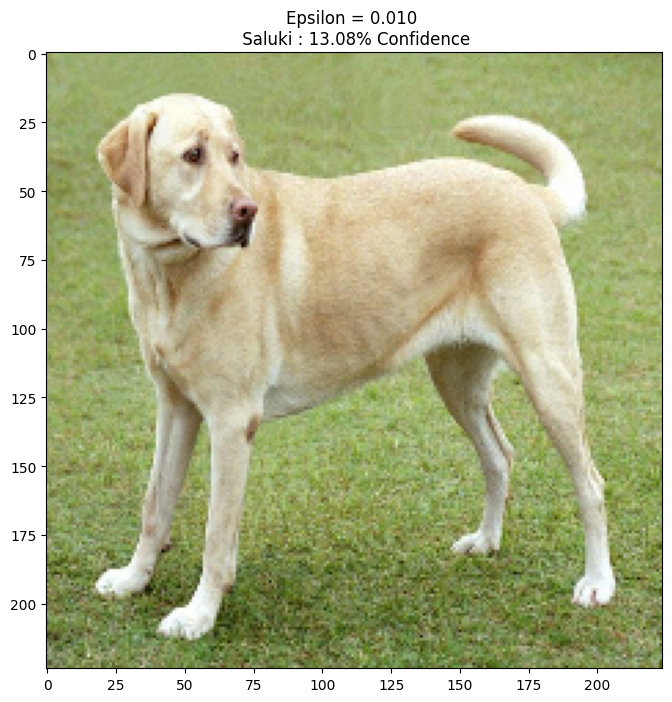

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


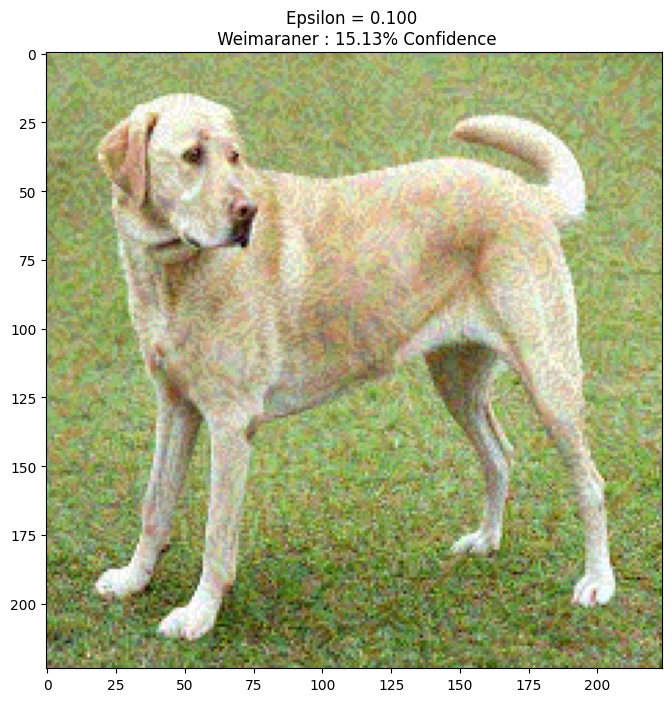

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


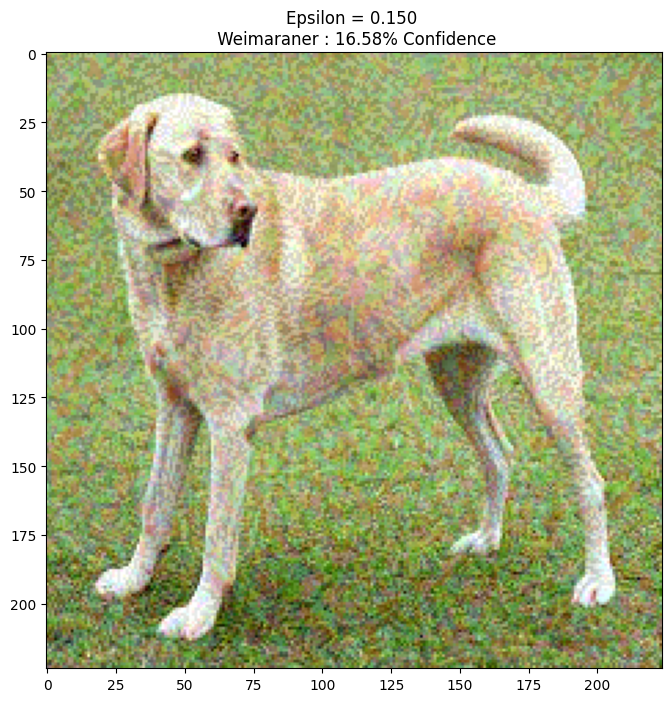

In [10]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

원래 모델 - '래브라도'라고 42% 확신
입실론 = 0.010 - '살루키'라고 13% 확신
입실론 = 0.100 - '바이마라너'라고 15% 확신